# 藻类脂质含量预测 — 完整处理流程

这个 notebook 包含从原始数据到特征筛选的全部步骤。我们的目标是预测藻类的脂质含量 `lipid(%)`。

数据来自实验室培养的藻类样本，共 36 个样本、29 个特征。样本量较小，所以处理时尽量保守，避免丢失数据。

**处理流程：**
1. 缺失值填充 — 用中位数填充，因为部分特征分布偏态
2. 特征工程 — 构造碳氮比、氮磷比等有生物学意义的指标
3. 异常值处理 — 盖帽法，把极端值拉回合理范围
4. 标准化 — Z-score，消除量纲影响
5. 特征筛选 — 四种方法综合比较，找出最重要的特征

## 环境准备

先把要用的库都导入，创建好输出目录。

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

os.makedirs('../data/processed', exist_ok=True)
os.makedirs('../results', exist_ok=True)

print('环境配置完成')

环境配置完成


## 第一步：加载数据并处理缺失值

先看看原始数据长什么样，有哪些缺失。

In [2]:
df = pd.read_excel('../data/raw/row_data.xlsx')
print(f'原始数据形状: {df.shape}')
print(f'缺失值统计:')
print(df.isnull().sum()[df.isnull().sum() > 0])

原始数据形状: (36, 29)
缺失值统计:
phosphate    8
N(%)         2
C(%)         2
S(%)         2
dtype: int64


In [3]:
# 看看缺失值的具体情况
missing_cols = ['phosphate', 'N(%)', 'C(%)', 'S(%)']

print('哪些样本有缺失：')
for col in missing_cols:
    missing_idx = df[df[col].isnull()].index.tolist()
    print(f'  {col}: {len(missing_idx)} 个缺失，在第 {missing_idx} 行')

# phosphate 缺失最多，看看它的分布是否偏态
# 如果偏态严重，用中位数填充比均值更合适
print()
print('检查 phosphate 的分布：')
phosphate_data = df['phosphate'].dropna()
skewness = stats.skew(phosphate_data)
print(f'  偏度 = {skewness:.2f}')

if abs(skewness) > 1:
    print(f'  → 偏度很大，分布严重偏斜，应该用中位数填充')
elif abs(skewness) > 0.5:
    print(f'  → 中度偏斜，建议用中位数')
else:
    print(f'  → 分布比较对称，均值或中位数都行')

哪些样本有缺失：
  phosphate: 8 个缺失，在第 [24, 25, 28, 29, 30, 31, 33, 35] 行
  N(%): 2 个缺失，在第 [23, 30] 行
  C(%): 2 个缺失，在第 [23, 30] 行
  S(%): 2 个缺失，在第 [23, 30] 行

检查 phosphate 的分布：
  偏度 = 3.23
  → 偏度很大，分布严重偏斜，应该用中位数填充


In [4]:
# 用中位数填充所有缺失值
df_filled = df.copy()

print('填充缺失值：')
for col in missing_cols:
    median_val = df_filled[col].median()
    n_missing = df_filled[col].isnull().sum()
    df_filled[col].fillna(median_val, inplace=True)
    print(f'  {col}: 用 {median_val:.4f} 填了 {n_missing} 个')

print(f'\\n检查：现在还有 {df_filled.isnull().sum().sum()} 个缺失值')

填充缺失值：
  phosphate: 用 0.0220 填了 8 个
  N(%): 用 3.6967 填了 2 个
  C(%): 用 45.9058 填了 2 个
  S(%): 用 0.3970 填了 2 个
\n检查：现在还有 0 个缺失值


In [5]:
output_path = '../data/processed/data_cleaned.xlsx'
df_filled.to_excel(output_path, index=False)
print(f'数据已保存至: {output_path}')
print(f'数据形状: {df_filled.shape}')

数据已保存至: ../data/processed/data_cleaned.xlsx
数据形状: (36, 29)


## 第二步：特征工程

构造几个有生物学意义的比例特征。碳氮比是脂质积累研究中常用的指标——氮源受限时，藻类会把多余的碳转向脂质合成。

In [6]:
df = df_filled.copy()

def safe_divide(numerator, denominator, name):
    """除法时保护一下，避免分母为 0 或太小导致极端值"""
    epsilon = 1e-6
    denom = denominator.replace(0, np.nan)
    denom = denom.where(denom.abs() >= epsilon, np.nan)
    result = numerator / denom
    
    # 如果产生了无效值，用中位数补上
    n_invalid = result.isna().sum() + np.isinf(result).sum()
    if n_invalid > 0:
        median_val = result.replace([np.inf, -np.inf], np.nan).median()
        result = result.replace([np.inf, -np.inf], np.nan).fillna(median_val)
        print(f'  注意：{name} 有 {n_invalid} 个无效值，已用中位数填充')
    return result

print('构造新特征：')

# 碳氮比：C/N 越高，理论上脂质积累越多
df['C_N_ratio'] = safe_divide(df['C(%)'], df['N(%)'], 'C_N_ratio')
print(f"  碳氮比 (C_N_ratio): {df['C_N_ratio'].min():.1f} ~ {df['C_N_ratio'].max():.1f}")

# 氮磷比：类似 Redfield 比，反映营养结构
df['N_P_ratio'] = safe_divide(df['TN'], df['TP'], 'N_P_ratio')
print(f"  氮磷比 (N_P_ratio): {df['N_P_ratio'].min():.1f} ~ {df['N_P_ratio'].max():.1f}")

# 氮磷转化效率比：探索性指标
df['N_P_conv_ratio'] = safe_divide(df['N conversion rate(%)'], df['P conversion rate(%)'], 'N_P_conv_ratio')
print(f"  转化效率比 (N_P_conv_ratio): {df['N_P_conv_ratio'].min():.1f} ~ {df['N_P_conv_ratio'].max():.1f}")

print(f'\\n现在共有 {df.shape[1]} 个特征')

构造新特征：
  碳氮比 (C_N_ratio): 7.0 ~ 24.5
  氮磷比 (N_P_ratio): 0.6 ~ 202.7
  转化效率比 (N_P_conv_ratio): 0.0 ~ 7.6
\n现在共有 32 个特征


In [7]:
output_path = '../data/processed/data_featured.xlsx'
df.to_excel(output_path, index=False)
print(f'数据已保存至: {output_path}')
print(f'数据形状: {df.shape}')

数据已保存至: ../data/processed/data_featured.xlsx
数据形状: (36, 32)


## 第三步：处理异常值

用盖帽法把极端值拉回来。选择 2.5 倍 IQR 作为阈值（比常见的 1.5 倍宽松），只处理真正离谱的值。这样既能防止极端值带偏模型，又能保留数据的自然变异。

In [8]:
def winsorize_column(series):
    """盖帽法：超出 Q1-2.5*IQR 或 Q3+2.5*IQR 的值，拉回到边界"""
    # 先把 inf 换成 NaN，不然算分位数会出问题
    series_clean = series.replace([np.inf, -np.inf], np.nan)
    
    Q1 = series_clean.quantile(0.25)
    Q3 = series_clean.quantile(0.75)
    IQR = Q3 - Q1
    
    if pd.isna(Q1) or pd.isna(Q3):
        return series_clean, np.nan, np.nan, 0, 0
    
    lower = Q1 - 2.5 * IQR
    upper = Q3 + 2.5 * IQR
    
    clipped = series_clean.clip(lower=lower, upper=upper)
    
    # 数一下有多少值被盖帽了
    valid = ~series_clean.isna()
    n_lower = (series_clean[valid] < lower).sum()
    n_upper = (series_clean[valid] > upper).sum()
    
    return clipped, lower, upper, n_lower, n_upper

In [9]:
# 对所有数值列做盖帽处理（目标变量 lipid% 不动）
df_capped = df.copy()
numeric_cols = df_capped.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols.remove('lipid(%)')

# 先处理掉可能存在的 inf
for col in numeric_cols:
    n_inf = np.isinf(df_capped[col]).sum()
    if n_inf > 0:
        df_capped[col] = df_capped[col].replace([np.inf, -np.inf], np.nan)

# 逐列盖帽
capped_cols = []
for col in numeric_cols:
    clipped, lower, upper, n_lower, n_upper = winsorize_column(df_capped[col])
    if n_lower + n_upper > 0:
        df_capped[col] = clipped
        capped_cols.append((col, n_lower + n_upper))

print(f'有 {len(capped_cols)} 个特征需要盖帽处理：')
for col, n in capped_cols:
    print(f'  {col}: {n} 个极端值')

有 10 个特征需要盖帽处理：
  Turbidity : 1 个极端值
  ammonia nitrogen: 1 个极端值
  phosphate: 8 个极端值
  TP: 6 个极端值
  Algal density（×10^5cells/ml): 3 个极端值
  Total photosynthetic pigments: 2 个极端值
  protein(%): 8 个极端值
  C(%): 1 个极端值
  C_N_ratio: 1 个极端值
  N_P_conv_ratio: 1 个极端值


In [10]:
output_path = '../data/processed/data_final.xlsx'
df_capped.to_excel(output_path, index=False)
print(f'数据已保存至: {output_path}')
print(f'数据形状: {df_capped.shape}')

数据已保存至: ../data/processed/data_final.xlsx
数据形状: (36, 32)


## 第四步：标准化

把所有特征缩放到同一尺度（均值 0，标准差 1），这样不同量纲的特征才能公平比较。目标变量 lipid% 保持原样。

In [11]:
df = df_capped.copy()
target_col = 'lipid(%)'
y = df[target_col].copy()

feature_cols = df.select_dtypes(include=[np.number]).columns.tolist()
feature_cols.remove(target_col)
X = df[feature_cols].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_cols, index=df.index)

print(f'标准化完成，共 {len(feature_cols)} 个特征')

# 验证一下：均值应该接近 0，标准差接近 1
print('\\n抽查几个特征：')
for col in feature_cols[:3]:
    m = X_scaled_df[col].mean()
    s = X_scaled_df[col].std(ddof=0)  # sklearn 用的是总体标准差
    print(f'  {col}: 均值={m:.4f}, 标准差={s:.4f}')

标准化完成，共 31 个特征
\n抽查几个特征：
  Turbidity : 均值=-0.0000, 标准差=1.0000
  Chroma: 均值=-0.0000, 标准差=1.0000
  pH : 均值=0.0000, 标准差=1.0000


In [12]:
df_standardized = X_scaled_df.copy()
df_standardized[target_col] = y

output_path = '../data/processed/data_standardized.xlsx'
df_standardized.to_excel(output_path, index=False)
print(f'数据已保存至: {output_path}')
print(f'数据形状: {df_standardized.shape}')

数据已保存至: ../data/processed/data_standardized.xlsx
数据形状: (36, 32)


## 第五步：特征筛选

用四种不同的方法来评估哪些特征最重要，然后综合比较。每种方法有各自的优缺点，综合起来看更稳健。

In [13]:
df = df_standardized.copy()
target_col = 'lipid(%)'
y = df[target_col].values

feature_cols = df.columns.tolist()
feature_cols.remove(target_col)

X = df[feature_cols].values

print(f'特征数量: {len(feature_cols)}')
print(f'样本数量: {len(y)}')

特征数量: 31
样本数量: 36


In [14]:
# 方法一：Pearson 相关系数
# 最简单直观，看特征和目标的线性相关程度

corr_scores = {}
for i, col in enumerate(feature_cols):
    if np.std(X[:, i]) == 0:  # 常量特征没法算相关
        corr_scores[col] = 0.0
        continue
    corr = np.corrcoef(X[:, i], y)[0, 1]
    corr_scores[col] = 0.0 if np.isnan(corr) else abs(corr)

print('【相关系数】前 5 名：')
for feat, score in sorted(corr_scores.items(), key=lambda x: -x[1])[:5]:
    print(f'  {feat}: {score:.3f}')

【相关系数】前 5 名：
  H(%): 0.404
  O(%): 0.339
  protein(%): 0.302
  Total photosynthetic pigments: 0.252
  BOD: 0.201


In [15]:
# 方法二：随机森林
# 能捕捉非线性关系，根据特征在树分裂时的贡献来打分

rf = RandomForestRegressor(n_estimators=100, max_depth=3, random_state=42, n_jobs=-1)
rf.fit(X, y)

rf_scores = dict(zip(feature_cols, rf.feature_importances_))

print('【随机森林】前 5 名：')
for feat, score in sorted(rf_scores.items(), key=lambda x: -x[1])[:5]:
    print(f'  {feat}: {score:.4f}')

【随机森林】前 5 名：
  H(%): 0.2265
  O(%): 0.1825
  protein(%): 0.0640
  S(%): 0.0579
  nitrate nitrogen: 0.0573


In [16]:
# 方法三：PLS 回归 (VIP 得分)
# VIP > 1 通常认为是重要特征

n_samples, n_features = X.shape
n_components = min(2, n_samples - 1, n_features)  # 小样本时要小心

pls = PLSRegression(n_components=n_components)
pls.fit(X, y)

def calculate_vip(model):
    """计算 VIP 得分"""
    t = model.x_scores_
    w = model.x_weights_
    q = model.y_loadings_
    p, h = w.shape
    
    s = np.diag(t.T @ t @ q.T @ q).reshape(h, -1)
    total_s = np.sum(s)
    if total_s == 0:
        return np.zeros(p)
    
    vips = np.zeros(p)
    for i in range(p):
        weight = np.array([(w[i,j] / np.linalg.norm(w[:,j]))**2 for j in range(h)])
        vips[i] = np.sqrt(p * (s.T @ weight) / total_s)
    return vips

pls_scores = dict(zip(feature_cols, calculate_vip(pls)))

print('【PLS VIP】前 5 名：')
for feat, score in sorted(pls_scores.items(), key=lambda x: -x[1])[:5]:
    print(f'  {feat}: {score:.3f}')

【PLS VIP】前 5 名：
  H(%): 2.232
  O(%): 1.860
  protein(%): 1.682
  pH : 1.554
  Total photosynthetic pigments: 1.465


In [17]:
# 方法四：递归特征消除 (RFE)
# 反复训练模型，每次剔除最不重要的特征，最后看哪些留到了最后

base_model = RidgeCV(alphas=[0.01, 0.1, 1.0, 10.0, 100.0])
rfe = RFE(estimator=base_model, n_features_to_select=6, step=1)
rfe.fit(X, y)

# 排名转成分数：越晚被剔除，分数越高
max_rank = max(rfe.ranking_)
rfe_scores = {col: max_rank - rfe.ranking_[i] + 1 for i, col in enumerate(feature_cols)}

print('【RFE】最终保留的 6 个特征：')
for feat in np.array(feature_cols)[rfe.support_]:
    print(f'  {feat}')

【RFE】最终保留的 6 个特征：
  pH 
  COD
  Total photosynthetic pigments
  protein(%)
  H(%)
  O(%)


In [18]:
# 综合四种方法的结果
# 先把各方法的分数归一化到 0-1，再取平均

def normalize(scores):
    vals = np.array(list(scores.values()))
    vals = np.nan_to_num(vals, nan=0.0)
    if vals.max() - vals.min() > 0:
        normed = (vals - vals.min()) / (vals.max() - vals.min())
    else:
        normed = np.zeros_like(vals)
    return dict(zip(scores.keys(), normed))

summary_df = pd.DataFrame({
    'feature': feature_cols,
    'Corr_Raw': [corr_scores[f] for f in feature_cols],
    'RF_Raw': [rf_scores[f] for f in feature_cols],
    'PLS_Raw': [pls_scores[f] for f in feature_cols],
    'RFE_Raw': [rfe_scores[f] for f in feature_cols],
    'Correlation': [normalize(corr_scores)[f] for f in feature_cols],
    'RandomForest': [normalize(rf_scores)[f] for f in feature_cols],
    'PLS': [normalize(pls_scores)[f] for f in feature_cols],
    'RFE': [normalize(rfe_scores)[f] for f in feature_cols]
})

summary_df['Average'] = summary_df[['Correlation', 'RandomForest', 'PLS', 'RFE']].mean(axis=1)
summary_df = summary_df.sort_values('Average', ascending=False)

print('【综合排名】前 10 名：')
print(summary_df[['feature', 'Average']].head(10).to_string(index=False))

【综合排名】前 10 名：
                      feature  Average
                         H(%) 1.000000
                         O(%) 0.867658
                   protein(%) 0.693172
Total photosynthetic pigments 0.577032
                          pH  0.533171
                          COD 0.419348
                          BOD 0.415893
              Dry cell weight 0.394425
                           DO 0.384115
                    phosphate 0.359713


## 可视化和保存结果

画个图直观比较一下四种方法的结果。

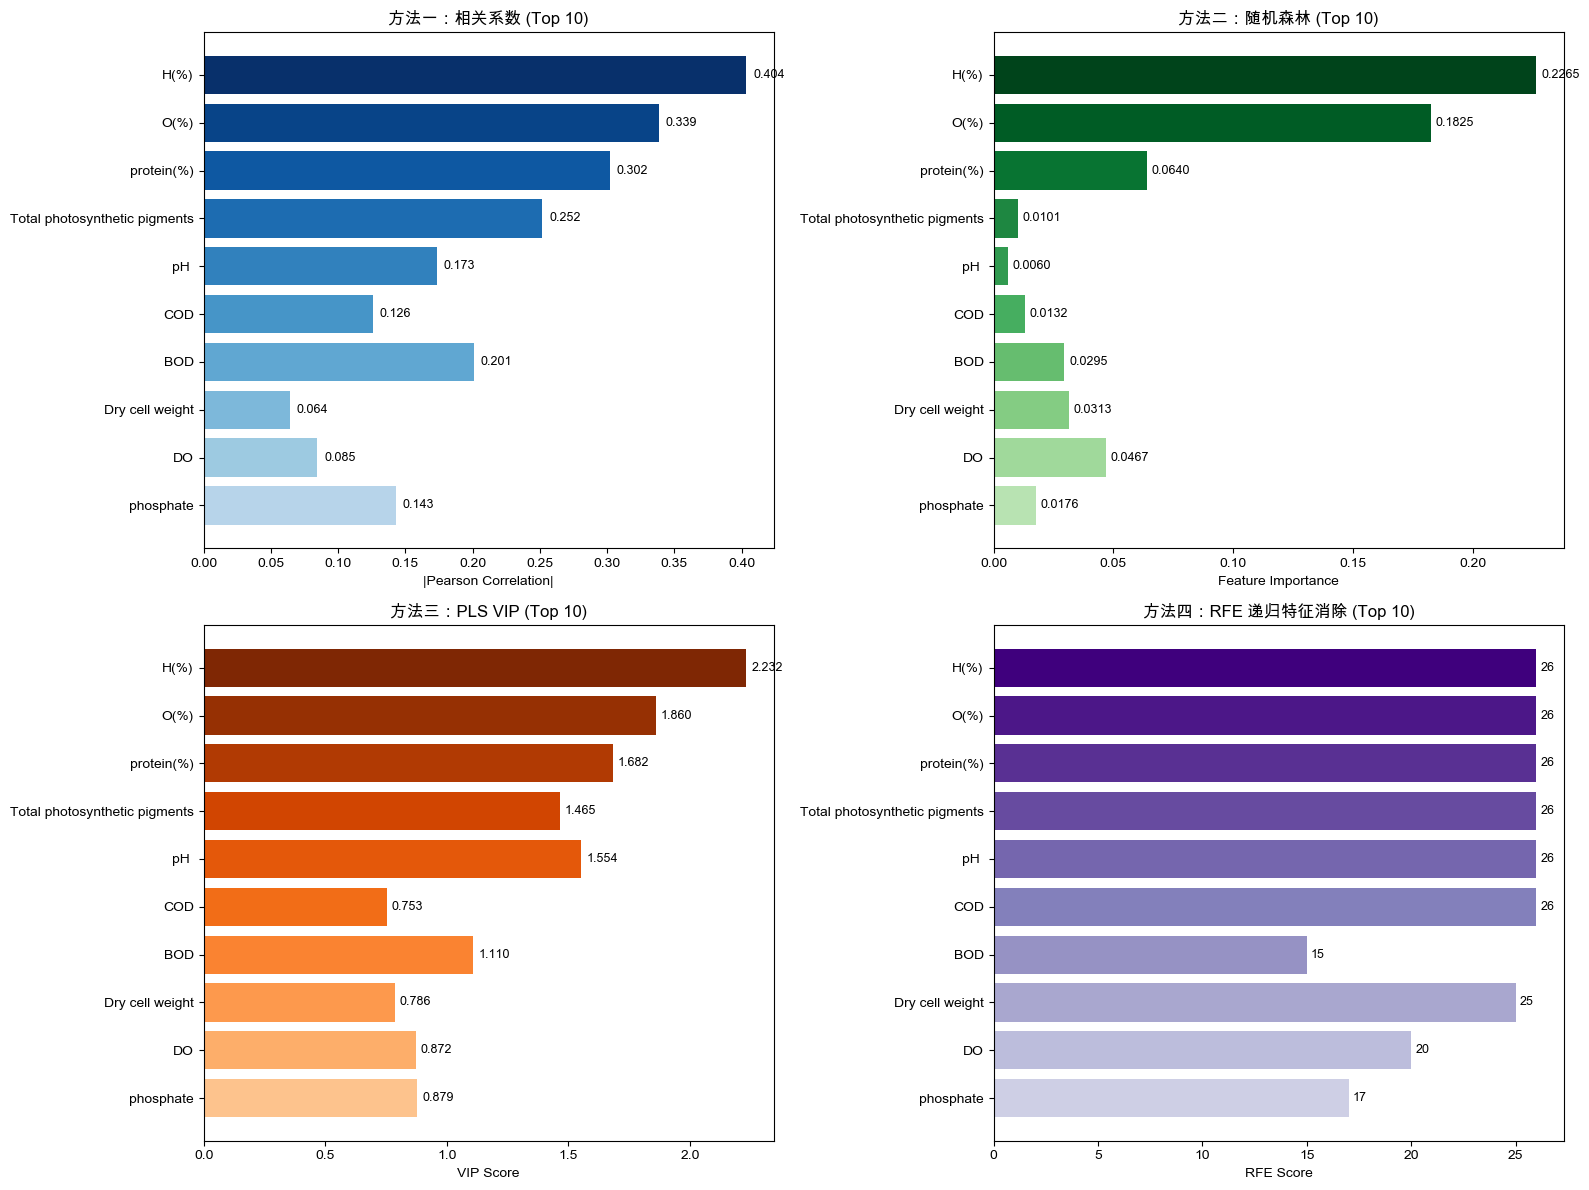

图表已保存至: ../results/feature_selection_comparison.png


In [19]:
top_n = 10
top_features = summary_df.head(top_n)['feature'].tolist()
plot_df = summary_df[summary_df['feature'].isin(top_features)].copy()
plot_df = plot_df.set_index('feature')

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 左上：相关系数
ax1 = axes[0, 0]
corr_values = plot_df.loc[top_features, 'Corr_Raw'].values
colors = plt.cm.Blues(np.linspace(0.3, 1, top_n))[::-1]
ax1.barh(top_features, corr_values, color=colors)
ax1.set_xlabel('|Pearson Correlation|')
ax1.set_title('方法一：相关系数 (Top 10)')
ax1.invert_yaxis()
for i, v in enumerate(corr_values):
    ax1.text(v + 0.005, i, f'{v:.3f}', va='center', fontsize=9)

# 右上：随机森林
ax2 = axes[0, 1]
rf_values = plot_df.loc[top_features, 'RF_Raw'].values
colors = plt.cm.Greens(np.linspace(0.3, 1, top_n))[::-1]
ax2.barh(top_features, rf_values, color=colors)
ax2.set_xlabel('Feature Importance')
ax2.set_title('方法二：随机森林 (Top 10)')
ax2.invert_yaxis()
for i, v in enumerate(rf_values):
    ax2.text(v + 0.002, i, f'{v:.4f}', va='center', fontsize=9)

# 左下：PLS VIP
ax3 = axes[1, 0]
pls_values = plot_df.loc[top_features, 'PLS_Raw'].values
colors = plt.cm.Oranges(np.linspace(0.3, 1, top_n))[::-1]
ax3.barh(top_features, pls_values, color=colors)
ax3.set_xlabel('VIP Score')
ax3.set_title('方法三：PLS VIP (Top 10)')
ax3.invert_yaxis()
for i, v in enumerate(pls_values):
    ax3.text(v + 0.02, i, f'{v:.3f}', va='center', fontsize=9)

# 右下：RFE
ax4 = axes[1, 1]
rfe_values = plot_df.loc[top_features, 'RFE_Raw'].values
colors = plt.cm.Purples(np.linspace(0.3, 1, top_n))[::-1]
ax4.barh(top_features, rfe_values, color=colors)
ax4.set_xlabel('RFE Score')
ax4.set_title('方法四：RFE 递归特征消除 (Top 10)')
ax4.invert_yaxis()
for i, v in enumerate(rfe_values):
    ax4.text(v + 0.2, i, f'{v:.0f}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('../results/feature_selection_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print('图表已保存至: ../results/feature_selection_comparison.png')

In [20]:
# 保存结果
summary_df.to_excel('../results/feature_selection_results.xlsx', index=False)

print('结果已保存')
print()
print('=== 处理完成 ===')
print()
print('推荐的前 10 个特征：')
for i, feat in enumerate(summary_df.head(10)['feature'].tolist(), 1):
    print(f'  {i}. {feat}')

结果已保存

=== 处理完成 ===

推荐的前 10 个特征：
  1. H(%)
  2. O(%)
  3. protein(%)
  4. Total photosynthetic pigments
  5. pH 
  6. COD
  7. BOD
  8. Dry cell weight
  9. DO
  10. phosphate
